In [ ]:
# Import Library
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.17.0


In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rivaldofernandes","key":"3d6370ce24c4d6bfc63a819f929e959b"}'}

In [ ]:
!rm -rf tomatoleaf/

In [ ]:
!pip install kaggle

In [ ]:
# Connect kaggle to colab
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download kaggle dataset and unzip the file
!kaggle datasets download -d kaustubhb999/tomatoleaf
!unzip tomatoleaf.zip

Streaming output truncated to the last 5000 lines.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b91-afe3-4c72-86b

In [ ]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "tomato/train"
test_dir = "tomato/val"

# Direktori baru untuk dataset gabungan
combined_dir = "tomato/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

old_dir = 'tomato/dataset/Tomato___Spider_mites Two-spotted_spider_mite'
new_dir = 'tomato/dataset/Tomato___Spider_mites'

os.rename(old_dir, new_dir)

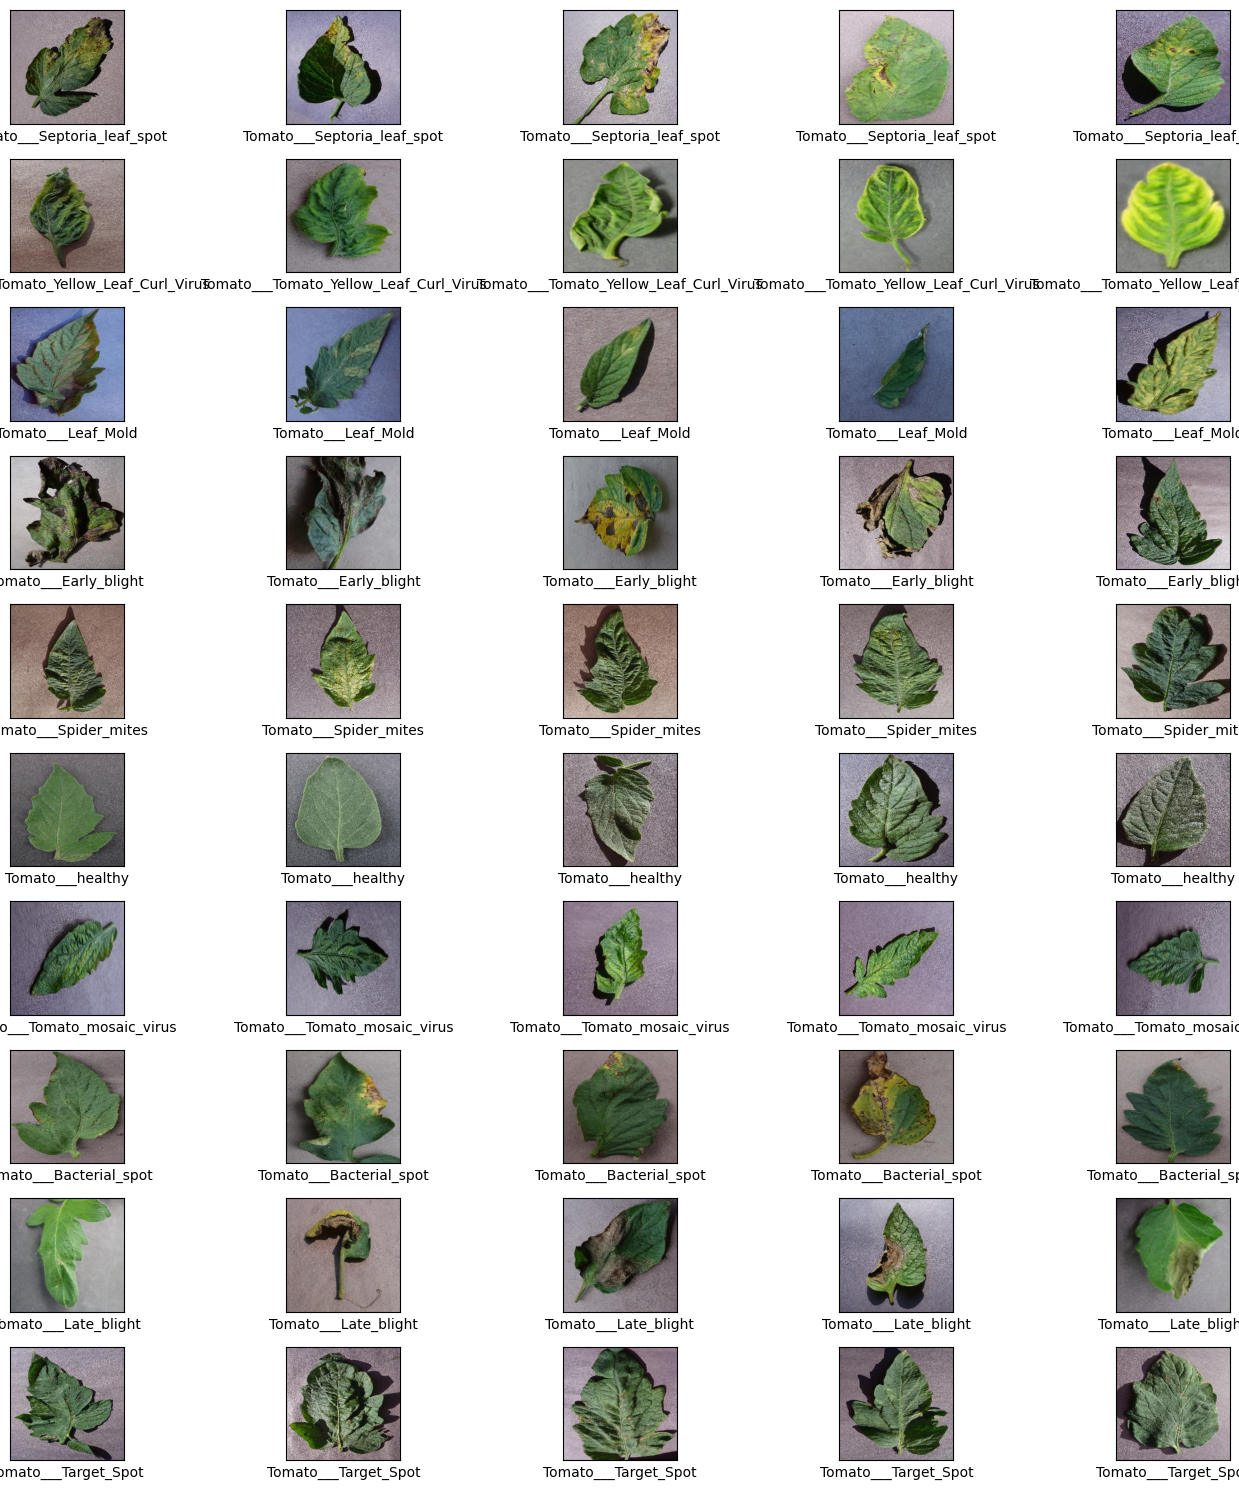

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
tomato_image = {}

# Tentukan path sumber train
path = "tomato/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    tomato_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "tomato/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(tomato_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(tomato_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

labels
Tomato___Septoria_leaf_spot               1100
Tomato___Tomato_Yellow_Leaf_Curl_Virus    1100
Tomato___Leaf_Mold                        1100
Tomato___Early_blight                     1100
Tomato___Spider_mites                     1100
Tomato___healthy                          1100
Tomato___Tomato_mosaic_virus              1100
Tomato___Bacterial_spot                   1100
Tomato___Late_blight                      1100
Tomato___Target_Spot                      1100
Name: count, dtype: int64


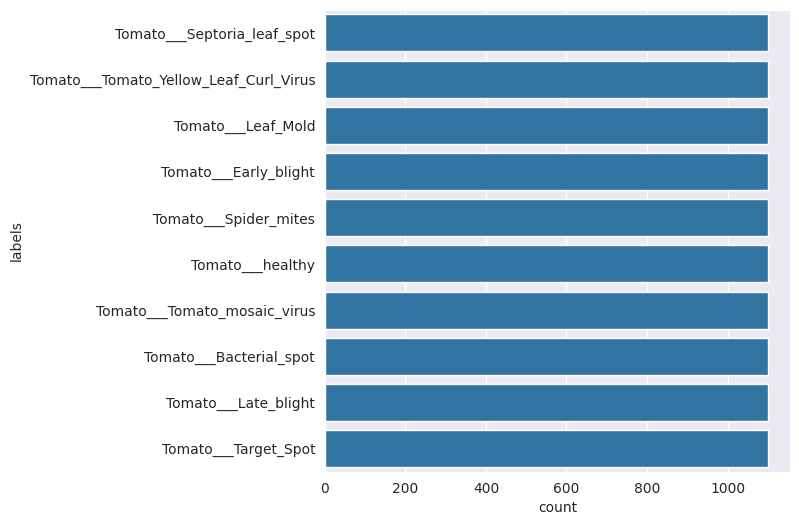

In [ ]:
# Define source path
tomato_path = "tomato/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(tomato_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Print the count of each category
print(distribution_train['labels'].value_counts())

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import os
import cv2
from skimage import io
from skimage import img_as_ubyte

# Define the transformations
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_paths = [
    ("tomato/dataset/Tomato___Bacterial_spot", "tomato/dataset/Tomato___Bacterial_spot"),
    ("tomato/dataset/Tomato___Early_blight", "tomato/dataset/Tomato___Early_blight"),
    ("tomato/dataset/Tomato___Late_blight", "tomato/dataset/Tomato___Late_blight"),
    ("tomato/dataset/Tomato___Leaf_Mold", "tomato/dataset/Tomato___Leaf_Mold"),
    ("tomato/dataset/Tomato___Septoria_leaf_spot", "tomato/dataset/Tomato___Septoria_leaf_spot"),
    ("tomato/dataset/Tomato___Spider_mites", "tomato/dataset/Tomato___Spider_mites"),
    ("tomato/dataset/Tomato___Target_Spot", "tomato/dataset/Tomato___Target_Spot"),
    ("tomato/dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus", "tomato/dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus"),
    ("tomato/dataset/Tomato___Tomato_mosaic_virus", "tomato/dataset/Tomato___Tomato_mosaic_virus"),
    ("tomato/dataset/Tomato___healthy", "tomato/dataset/Tomato___healthy")
]

images_to_generate = [
    (5000, images_paths[0][0], images_paths[0][1]),
    (5000, images_paths[1][0], images_paths[1][1]),
    (5000, images_paths[2][0], images_paths[2][1]),
    (5000, images_paths[3][0], images_paths[3][1]),
    (5000, images_paths[4][0], images_paths[4][1]),
    (5000, images_paths[5][0], images_paths[5][1]),
    (5000, images_paths[6][0], images_paths[6][1]),
    (5000, images_paths[7][0], images_paths[7][1]),
    (5000, images_paths[8][0], images_paths[8][1]),
    (5000, images_paths[9][0], images_paths[9][1])
]

for num_images, original_path, aug_path in images_to_generate:
    i = 1
    while i <= num_images:
        image_path = random.choice(os.listdir(original_path))
        image = os.path.join(original_path, image_path)
        try:
            try:
                original_image = io.imread(image)
            except Exception as e:
                print(f"Error reading image {image}: {e}. Skipping...")
                continue

            original_image = original_image / 255.0  # Normalize image values to be between 0 and 1
            if original_image.min() < -1 or original_image.max() > 1:
                print(f"Image {image} has values outside the range of -1 to 1. Skipping...")
                continue
            original_image = original_image - 1.0  # Shift image values to be between -1 and 1

            # Rest of the code remains the same

            # Check if the image has valid dimensions (3 or 4 dimensions)
            if original_image.ndim not in [3, 4]:
                raise ValueError('Invalid image dimensions')

            transformed_image = None
            n = 0  # Variable to iterate until the specified number of transformations
            transformation_count = random.randint(1, len(transformations))  # Randomly select the number of transformations to apply

            while n <= transformation_count:
                key = random.choice(list(transformations))  # Randomly select and call the transformation method
                transformed_image = transformations[key](original_image)
                n = n + 1

            filename, file_extension = os.path.splitext(image_path)
            new_image_path = os.path.join(aug_path, f"augmented_{filename}{file_extension}")
            transformed_image = transformed_image* 255
            transformed_image = np.array(transformed_image, dtype=np.uint8)
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            print(f"Berhasil")
            i = i + 1
        except ValueError as e:
            print('Could not read or process the image', image, ':', e, 'hence skipping it.')

Streaming output truncated to the last 5000 lines.
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berhasil
Berh

In [ ]:
# Define source path
tomato_path = "tomato/dataset"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(tomato_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Print the count of each category
print(distribution_train['labels'].value_counts())

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'tomato/dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Tomato___Bacterial_spot,3516
Tomato___Early_blight,3523
Tomato___Late_blight,3473
Tomato___Leaf_Mold,3497
Tomato___Septoria_leaf_spot,3458
Tomato___Spider_mites,3480
Tomato___Target_Spot,3458
Tomato___Tomato_Yellow_Leaf_Curl_Virus,3532
Tomato___Tomato_mosaic_virus,3486


In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 27945
test size 6987


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels                                
test   Tomato___Bacterial_spot                    745
       Tomato___Early_blight                      686
       Tomato___Late_blight                       667
       Tomato___Leaf_Mold                         713
       Tomato___Septoria_leaf_spot                674
       Tomato___Spider_mites                      702
       Tomato___Target_Spot                       718
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     723
       Tomato___Tomato_mosaic_virus               653
       Tomato___healthy                           706
train  Tomato___Bacterial_spot                   2771
       Tomato___Early_blight                     2837
       Tomato___Late_blight                      2806
       Tomato___Leaf_Mold                        2784
       Tomato___Septoria_leaf_spot               2784
       Tomato___Spider_mites                     2778
       Tomato___Target_Spot                      2740
       Tomato___Tomato_Yellow_Leaf_

In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "tomato/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_Tomato___Bacterial_spot = os.path.join(TRAIN_DIR + '/Tomato___Bacterial_spot')
train_Tomato___Early_blight = os.path.join(TRAIN_DIR + '/Tomato___Early_blight')
train_Tomato___Late_blight = os.path.join(TRAIN_DIR + '/Tomato___Late_blight')
train_Tomato___Leaf_Mold = os.path.join(TRAIN_DIR + '/Tomato___Leaf_Mold')
train_Tomato___Septoria_leaf_spot = os.path.join(TRAIN_DIR + '/Tomato___Septoria_leaf_spot')
train_Tomato___Spider_mites = os.path.join(TRAIN_DIR + '/Tomato___Spider_mites')
train_Tomato___Target_Spot = os.path.join(TRAIN_DIR + '/Tomato___Target_Spot')
train_Tomato___Tomato_Yellow_Leaf_Curl_Virus = os.path.join(TRAIN_DIR + '/Tomato___Tomato_Yellow_Leaf_Curl_Virus')
train_Tomato___Tomato_mosaic_virus = os.path.join(TRAIN_DIR + '/Tomato___Tomato_mosaic_virus')
train_Tomato___healthy = os.path.join(TRAIN_DIR + '/Tomato___healthy')

test_Tomato___Bacterial_spot = os.path.join(TEST_DIR + '/Tomato___Bacterial_spot')
test_Tomato___Early_blight = os.path.join(TEST_DIR + '/Tomato___Early_blight')
test_Tomato___Late_blight = os.path.join(TEST_DIR + '/Tomato___Late_blight')
test_Tomato___Leaf_Mold = os.path.join(TEST_DIR + '/Tomato___Leaf_Mold')
test_Tomato___Septoria_leaf_spot = os.path.join(TEST_DIR + '/Tomato___Septoria_leaf_spot')
test_Tomato___Spider_mites = os.path.join(TEST_DIR + '/Tomato___Spider_mites')
test_Tomato___Target_Spot = os.path.join(TEST_DIR + '/Tomato___Target_Spot')
test_Tomato___Tomato_Yellow_Leaf_Curl_Virus = os.path.join(TEST_DIR + '/Tomato___Tomato_Yellow_Leaf_Curl_Virus')
test_Tomato___Tomato_mosaic_virus = os.path.join(TEST_DIR + '/Tomato___Tomato_mosaic_virus')
test_Tomato___healthy = os.path.join(TEST_DIR + '/Tomato___healthy')

print("Total number of Tomato___Bacterial_spot images in training set: ",len(os.listdir(train_Tomato___Bacterial_spot)))
print("Total number of Tomato___Early_blight images in training set: ",len(os.listdir(train_Tomato___Early_blight)))
print("Total number of Tomato___Late_blight images in training set: ",len(os.listdir(train_Tomato___Late_blight)))
print("Total number of Tomato___Leaf_Mold images in training set: ",len(os.listdir(train_Tomato___Leaf_Mold)))
print("Total number of Tomato___Septoria_leaf_spot images in training set: ",len(os.listdir(train_Tomato___Septoria_leaf_spot)))
print("Total number of Tomato___Spider_mites images in training set: ",len(os.listdir(train_Tomato___Spider_mites)))
print("Total number of Tomato___Target_Spot images in training set: ",len(os.listdir(train_Tomato___Target_Spot)))
print("Total number of Tomato___Tomato_Yellow_Leaf_Curl_Virus images in training set: ",len(os.listdir(train_Tomato___Tomato_Yellow_Leaf_Curl_Virus)))
print("Total number of Tomato___Tomato_mosaic_virus images in training set: ",len(os.listdir(train_Tomato___Tomato_mosaic_virus)))
print("Total number of Tomato___healthy images in training set: ",len(os.listdir(train_Tomato___healthy)))
print("\n")
print("Total number of Tomato___Bacterial_spot images in test set: ",len(os.listdir(test_Tomato___Bacterial_spot)))
print("Total number of Tomato___Early_blight images in test set: ",len(os.listdir(test_Tomato___Early_blight)))
print("Total number of Tomato___Late_blight images in test set: ",len(os.listdir(test_Tomato___Late_blight)))
print("Total number of Tomato___Leaf_Mold images in test set: ",len(os.listdir(test_Tomato___Leaf_Mold)))
print("Total number of Tomato___Septoria_leaf_spot images in test set: ",len(os.listdir(test_Tomato___Septoria_leaf_spot)))
print("Total number of Tomato___Spider_mites images in test set: ",len(os.listdir(test_Tomato___Spider_mites)))
print("Total number of Tomato___Target_Spot images in test set: ",len(os.listdir(test_Tomato___Target_Spot)))
print("Total number of Tomato___Tomato_Yellow_Leaf_Curl_Virus images in test set: ",len(os.listdir(test_Tomato___Tomato_Yellow_Leaf_Curl_Virus)))
print("Total number of Tomato___Tomato_mosaic_virus images in test set: ",len(os.listdir(test_Tomato___Tomato_mosaic_virus)))
print("Total number of Tomato___healthy images in test set: ",len(os.listdir(test_Tomato___healthy)))

Total number of Tomato___Bacterial_spot images in training set:  2771
Total number of Tomato___Early_blight images in training set:  2837
Total number of Tomato___Late_blight images in training set:  2806
Total number of Tomato___Leaf_Mold images in training set:  2784
Total number of Tomato___Septoria_leaf_spot images in training set:  2784
Total number of Tomato___Spider_mites images in training set:  2778
Total number of Tomato___Target_Spot images in training set:  2740
Total number of Tomato___Tomato_Yellow_Leaf_Curl_Virus images in training set:  2809
Total number of Tomato___Tomato_mosaic_virus images in training set:  2833
Total number of Tomato___healthy images in training set:  2803


Total number of Tomato___Bacterial_spot images in test set:  745
Total number of Tomato___Early_blight images in test set:  686
Total number of Tomato___Late_blight images in test set:  667
Total number of Tomato___Leaf_Mold images in test set:  713
Total number of Tomato___Septoria_leaf_spot im

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_dirs = [f for f in os.listdir(TRAIN_DIR) if not f.startswith('.')]

datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    classes=train_dirs,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    classes=train_dirs,
    shuffle=True
)

Found 27945 images belonging to 10 classes.
Found 6987 images belonging to 10 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

# Buat model
model = Sequential()

# Tambahkan lapisan konvolusi dan pooling
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Tambahkan lapisan flatten
model.add(Flatten())

# Tambahkan lapisan dense
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Tambah Dropout layer dengan tingkat dropout 0.5

# Tambahkan lapisan output
model.add(Dense(10, activation='softmax'))

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definisikan early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, min_delta=0.01, mode='max', restore_best_weights=True)

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,662,474 (13.97 MB)

 Trainable params: 3,662,474 (13.97 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history_1 = model.fit(train_generator,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


874/874 ━━━━━━━━━━━━━━━━━━━━ 89s 98ms/step - accuracy: 0.3066 - loss: 1.8671 - val_accuracy: 0.6419 - val_loss: 1.0756
Epoch 2/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.6132 - loss: 1.0794 - val_accuracy: 0.7823 - val_loss: 0.6535
Epoch 3/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.7180 - loss: 0.7995 - val_accuracy: 0.8251 - val_loss: 0.4924
Epoch 4/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.7703 - loss: 0.6453 - val_accuracy: 0.8414 - val_loss: 0.4549
Epoch 5/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 75s 85ms/step - accuracy: 0.8046 - loss: 0.5459 - val_accuracy: 0.8851 - val_loss: 0.3495
Epoch 6/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.8392 - loss: 0.4513 - val_accuracy: 0.8496 - val_loss: 0.4443
Epoch 7/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.8575 - loss: 0.3972 - val_accuracy: 0.9087 - val_loss: 0.2797
Epoch 8/50
874/874 ━━━━━━━━━━━━━━━━━━━━ 74s 85ms/step - accuracy: 0.8757 - loss: 0.3392 - val_accurac

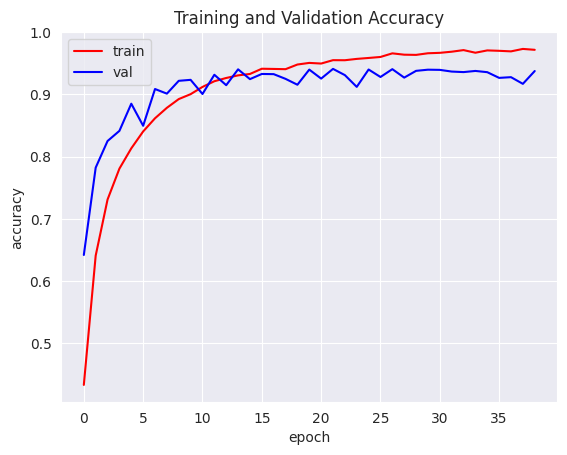

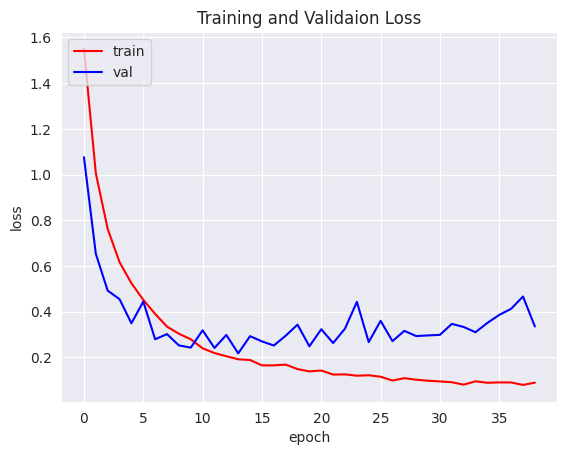

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

Saving mitestomato.jpg to mitestomato.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


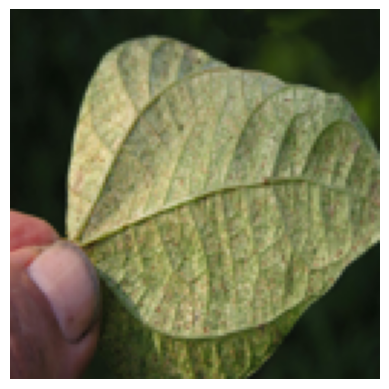

Predicted label (desease): Spider Mites


In [ ]:
from google.colab import files
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Upload an image manually
uploaded = files.upload()

# Get the uploaded image file
img_file = list(uploaded.keys())[0]

# Open the image file
img = Image.open(img_file)

# Resize the image to match the model's input shape
img = img.resize((128, 128))

# Convert the image to a numpy array
img_array = np.array(img)

# Normalize the image
img_array = img_array / 255.0

# Add a batch dimension
img_array = np.expand_dims(img_array, 0)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)

# Define the class labels
class_labels = ['Bacterial Spot', 'Early Blight', 'Late Blight', 'Leaf Mold', 'Septoria Leaf Spot', 'Spider Mites', 'Target Spot', 'Yellow Leaf Curl Virus', 'Mosaic Virus', 'Healty']

# Get the class label
predicted_label = class_labels[predicted_class[0]]

# Display the uploaded image without axes
plt.imshow(img)
plt.axis('off')
plt.show()

print("Predicted label (desease):", predicted_label)

In [ ]:
model.save("model.h5")

In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
2024-08-24 01:35:21.510178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 01:35:21.531360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 01:35:21.539199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to re

In [ ]:
import tensorflow as tf

# Load model .h5
model = tf.keras.models.load_model("model.h5")

# Konversi model ke .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save model .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
save_path = os.path.join("models/rps_model/1/")
tf.saved_model.save(model, save_path)

Saved artifact at '/tmp/tmp74dfeck7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135703076556992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135703076555408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135702988933776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135702988933952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135702988944864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135702989031552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135702989043520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135702989044048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135702987082208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135702987088544: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==0.32.1
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.13
albumentations==1.4.14
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.2
astropy-iers-data==0.2024.8.19.0.32.16
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.6.2
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.15.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.7.4
cffi==1.17.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.18.1
cloudpickle==2.2.1
cmake==3.30.2
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confe